# SmartCampaingBase 

Basic campaign which allows change alpha and campaign risk adjustment metrics, but doesn't support alpha rebalancing / weighting.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import numpy as np
%pylab inline

Populating the interactive namespace from numpy and matplotlib


## Smart campaign definition

In [3]:
CAMPAIGN_DICT = {
    'name': "BasicSmartCampaign",
    
    # Allowed values for both ALPHA_RISK_TYPE and CAMPAIGN_RISK_TYPE

    # 'atr' - ATR(RISK_PERIOD) of alpha/campaign equity risk metric
    # 'atrmax' - Highest(ATR(RISK_PERIOD)) of alpha/campaign equity risk metric
    # 'ddavg' - rolling mean (RISK_PERIOD) of drawdown of alpha/campaign equity 
    # 'ddmax' - rolling maximum (RISK_PERIOD) of drawdown of alpha/campaign equity
    # 'ddq95' - rolling 95% quantile (RISK_PERIOD) of drawdown of alpha/campaign equity    
    'alpha_risk_type': 'atr',
    'alpha_risk_period': 100,
    'alpha_min_risk': 100,

    'campaign_risk_type': 'atrmax',
    'campaign_risk_period': 100,
    'campaign_min_risk': 100,
    
    #
    # Campaign definition
    #
    'alphas': {
        # Single alphas
        '!NEW_AlphaV1Exposure_HedgedBy_V2_US_ZN_EXO_PutSpread_DynKel_longs_DSP_BandPass__Bullish_2_Sept_7_21': {'tag': ''},
        
        # !! Risk reversal stack V1 + V2
        'ZN_ContFut_Long_Strategy_DSP_BandPass__Bullish_2_Sept_7__hedged': {
            'tag': '',
            'alphas': {
                'ZN_ContFut_Long_Strategy_DSP_BandPass__Bullish_2_Sept_7_custom': 1.0,
                '!NEW_AlphaV1Exposure_HedgedBy_V2_US_ZN_EXOSemiFuture_DynKel_20_60_longs_DSP_BandPass__Bullish_2_Sept_7_Oct_6': 1.0,
            }
        }
    }
}

### Loading smart campaign alphas

In [5]:
import pandas as pd
from smartcampaign import SmartCampaignBase
from smartcampaign.tools import *
import os

#
# Init V1 framework datasource
#
from exobuilder.data.exostorage import EXOStorage
from scripts.settings import *

storage = EXOStorage(MONGO_CONNSTR, MONGO_EXO_DB)



# Loading V1 and V2 alphas
alphas_list = SmartCampaignBase.get_alphas_list_from_settings(CAMPAIGN_DICT)
alphas_series_dict = storage.swarms_data(alphas_list, load_v2_alphas=True)
df_alphas_equities = {k: v['swarm_series'] for k,v in alphas_series_dict.items()}


# Backtesting

In [7]:
#
# Init Smart Campaign
#
scmp = SmartCampaignBase(CAMPAIGN_DICT, df_alphas_equities)

BACKTESTER_SETTINGS = {
    'start_date': datetime.datetime(2014, 1, 1),
    'initial_capital': 50000,
    'target_risk_percent': 0.01,    
}

bt_dict = scmp.backtest(**BACKTESTER_SETTINGS)

                                 MM             Adj Plain      Adj No Reinv   Simple Sum  
NetProfit $                         -10127.45      -10127.45      -11092.90        -794.31
NetProfit %                           -20.25%        -20.25%        -22.19%         -1.59%

MaxDD $                             -19558.48      -19558.48      -20453.18       -6429.19
MaxDD %                               -33.37%        -33.37%        -35.10%        -11.72%

MaxATR $                               546.60         546.60         548.67         198.96
Q95% ATR $                             516.52         516.52         523.56         190.91
Avg ATR $                              443.78         443.78         453.02         166.33

MaxATR %                                1.18%          1.18%          1.21%          0.38%
Q95% ATR %                              1.06%          1.06%          1.13%          0.37%
Avg ATR %                               0.93%          0.93%          0.96%          0.

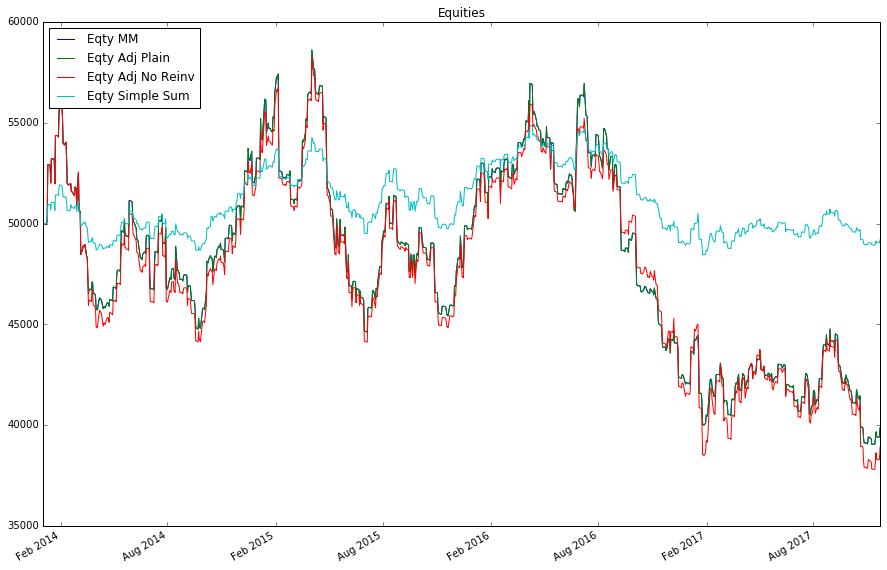

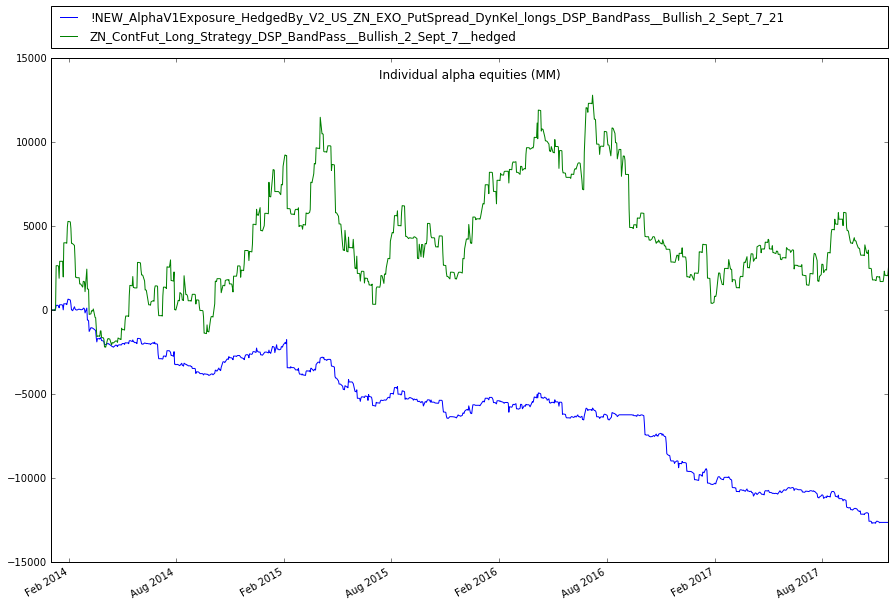

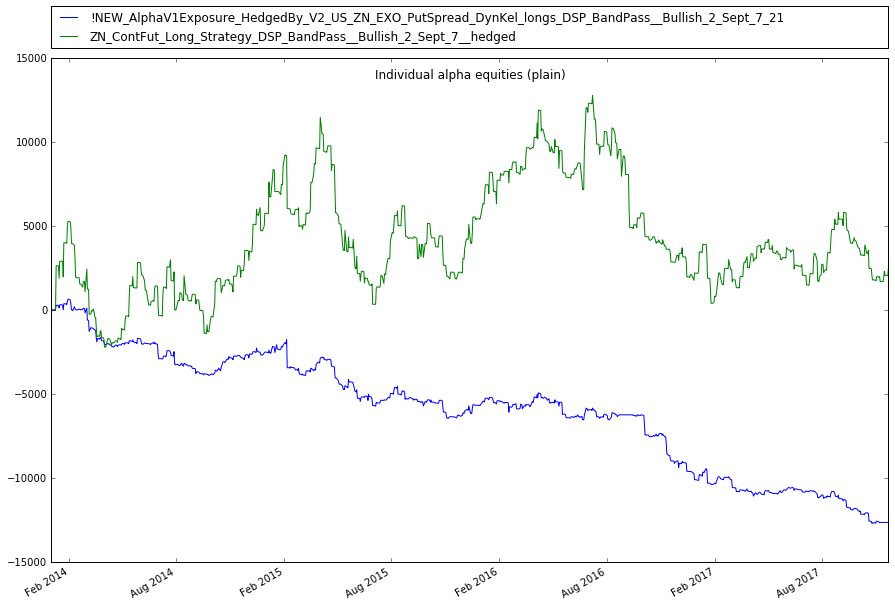

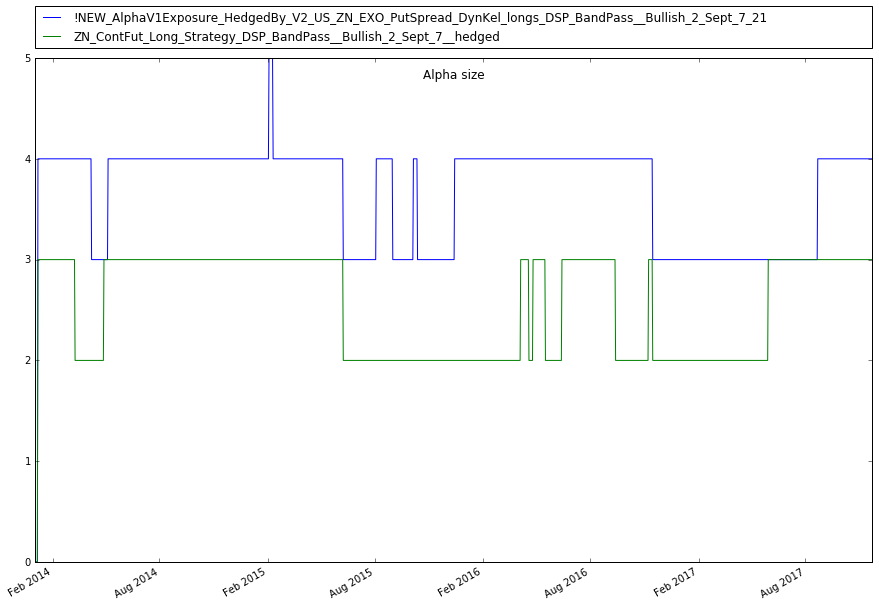

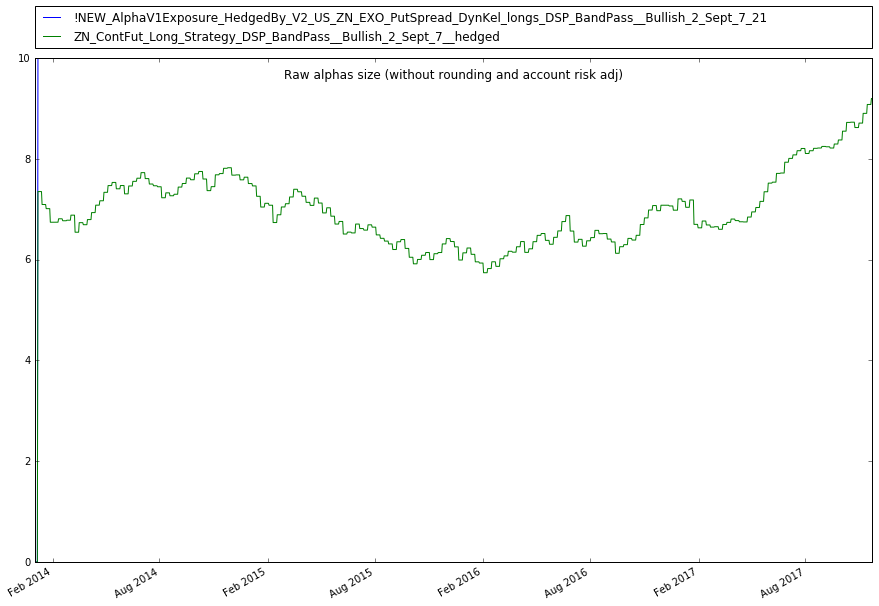

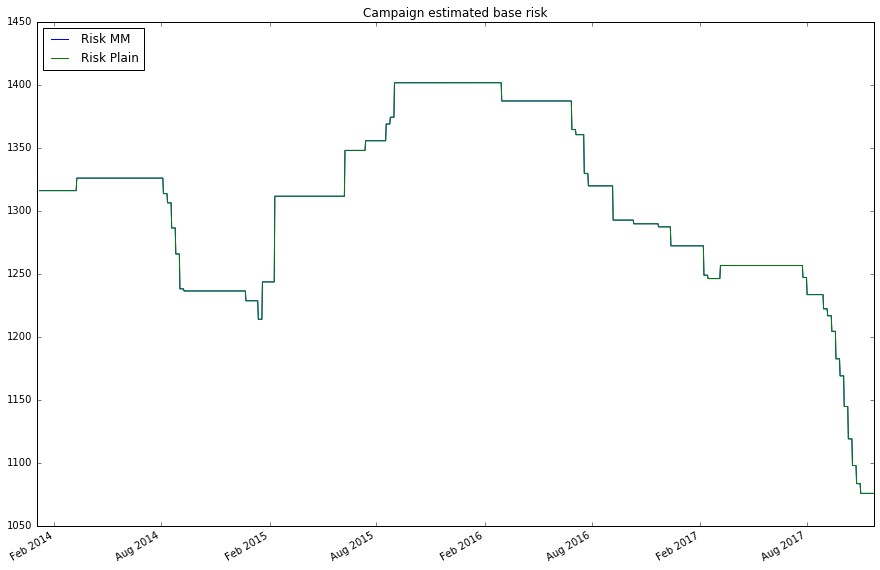

In [8]:
figsize(15, 10)
scmp.report(bt_dict)